# Project: Neural Style Transfer

Welcome to *Project: Neural Style Transfer*! Neural style transfer is an approach to modify a given image (the *Content Image*, usually a photo) such that it assimilates another given image (the *Style Image*, usually a painting) in terms of style. In doing that, of course we need an explicit definition of what we mean by *style*: A specific loss function is minimized which incorporates a pretrained convolutional neural network (CNN). A subset of layers of the CNN are used to compute a distance between the sought image (the *Generated Image*) and the *Content Image*, and between the *Generated Image* and the *Style Imgage*, respectively.

The underlying idea originates in the paper <a href="https://arxiv.org/pdf/1508.06576.pdf">A Neural Algorithm of Artistic Style</a> by Leon Gatys, Alexander Ecker and Matthias Bethge. It is assumed that outputs of CNN layers indicate whether or not areas of an input image contain certain learned patterns. Each filter in a CNN layer represents one pattern, and the deeper a filter is located in the network, the more complex and abstract can be the extracted information. While layer outputs (activations) can be used directly to derive a distance between content image and generated image, something more sophisticated is needed to measure similarity in style. To establish a style based distance, correlations (inner products) between all output channels of a CNN layer are computed and stored in a *Gram Matrix*. A comparison between *Style Image* and *Generated Image* is then accomplished in terms of several Gram matrices relating to different layers. More details can be found below, in the above-mentioned paper, and in the Stud.IP Courseware.

In this project, you will use the readily trained and available CNN <a href="https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19">VGG19</a> (see also <a href="https://arxiv.org/pdf/1409.1556.pdf">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> by Karen Simonyan Andrew Zisserman). In other words, our goal here is **not** to learn parameters of a neural network. We solely seek the *Generated Image*. However, you will learn fundamentals for an advanced usage of Keras and TensorFlow. To compute CNN activations and Gram matrices from inputs, you will need the <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=20c4897dea349b14eca5d904fda9504d&selected=1400901">Keras Functional API</a> as well as the <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=20c4897dea349b14eca5d904fda9504d&selected=1400902">Keras Subclassing API</a>. These two enable you to create custom models in Keras and surpass the possibilities of the <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=20c4897dea349b14eca5d904fda9504d&selected=1400900">Keras Sequential API</a> by far. Moreover, you will use <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=20c4897dea349b14eca5d904fda9504d&selected=1400905">TensorFlow functions</a> and <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=20c4897dea349b14eca5d904fda9504d&selected=1400896">automatic differentiation</a> in order to implement <a href="https://studip.tu-braunschweig.de/plugins.php/courseware/courseware?cid=20c4897dea349b14eca5d904fda9504d&selected=1400904">custom training loops</a> in TensorFlow.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tf.keras.backend.set_floatx('float64')

## 2.1 Loading and formatting images with TensorFlow

1. Write a function ```load_img(path_to_img, max_dim)``` that reads and resizes an image. The function shall return a 4D-tensor ```img``` of type ```tf.float64``` with values in the range ```[0,1]```. Height and width of the image shall be scaled such that the maximum of ```img.shape[1]``` (height in pixels) and ```img.shape[2]``` (width in pixels) is exactly ```max_dim```. Moreover, the output should feature ```img.shape[0] = 1``` (batch size) and ```img.shape[3] = 3``` (number of channels). Proceed as follows:

    1.1 Use ```tf.io.read_file```, ```tf.image.decode_image``` and ```tf.image.convert_image_dtype``` (in this order), to read and convert the input image.
    
    1.2 Use ```tf.image.resize``` to scale height and width by the same factor. Make sure that the maximum
    
    1.3 Use ```tf.expand_dims``` to add the batch dimension.
    
    1.4 Use ```tf.cast``` to make sure that the output has type ```tf.float64```.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_img(path_to_img, max_dim):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float64)
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = tf.expand_dims(img, axis = 0)
  img = tf.cast(img, tf.float64)
  return img

2. Call ```load_img``` with ```max_dim = 512``` to load ```altgebaeude.jpg``` and ```vangogh.jpg``` and store them in variables ```content_image``` and ```style_image```, respectively.


3. Use ```plt.imshow``` to display both images.

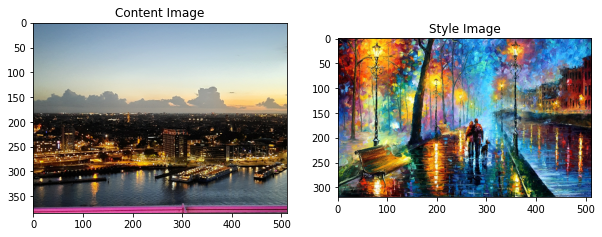

In [ ]:
content_path = "/content/drive/MyDrive/FPDS/project_2/neural_contest/content_image_4.jpg"
style_path = "/content/drive/MyDrive/FPDS/project_2/neural_contest/style_image_2.jpg"

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

content_image = load_img(content_path, max_dim = 512)
style_image = load_img(style_path, max_dim = 512)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')
plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

4. Apply ```tf.shape``` to ```content_image``` and ```style_image``` and diplay both outputs.

In [ ]:
print(tf.shape(content_image))
print(tf.shape(style_image))

tf.Tensor([  1 384 512   3], shape=(4,), dtype=int32)
tf.Tensor([  1 320 512   3], shape=(4,), dtype=int32)


## 2.2 Using pretrained models in Keras

```tf.keras.applications``` lets you load various readily trained neural networks, for example ```VGG19``` which we are going to use here. Before starting with Neural Style Transfer, let us see how to use a pretrained model for multiclass classification.

5. Call ```tf.keras.applications.VGG19``` with arguments ```include_top = True``` and ```weights = "imagenet"```, and store the output in a variable ```vgg```.

The first-mentioned argument is to get both the preceding convolutional layers *and* the subsequent fully connected layers at the top of ```VGG19```. Vice versa, ```include_top = False``` lets you load the network without fully connected layers. The version without fully connected layers has the advantage that images of arbitrary height and width are accepted as input and can be propagated through the network (we will make use of this for Neural Style Transfer). The variant you should have loaded now accepts only ```224 x 224``` images. The latter argument ```weights = "imagenet"``` implies that a network is loaded that was pretrained on the ```imagenet``` dataset. By means of ```weights = None```, you can also get a randomly initialized version.

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

574710816/574710816 [==============================] - 25s 0us/step


6. Use ```tf.keras.models.Model.summary``` to get an overview of the model.

In [ ]:
tf.keras.models.Model.summary(vgg)

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Each model in ```keras.applications``` has an own preprocessing function that should be applied to inputs before feeding them into the network. In case of ```VGG19```, the preprocessing function expects an image with integer pixel values between 0 and 255 as input.

7. Apply ```tf.keras.applications.vgg19.preprocess_input``` to a version of ```content_image``` with accordingly scaled pixel values and store the output in ```content_image_pp```. Afterwards, use ```tf.image.resize``` to rescale ```content_image_pp``` such that you can apply ```vgg``` to the result ```content_image_rs```. Do the latter and store the output of ```vgg``` in ```predicted_probabilities```.

In [ ]:
content_image_pp = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image_rs = tf.image.resize(content_image_pp, (224, 224))
prediction_probabilities = vgg(content_image_rs)

8. Now call ```tf.keras.applications.vgg19.decode_predictions``` with arguments ```predicted_probabilities.numpy()``` and ```top = 10``` to display the top 10 classes and associated probabilities for the given input. Store the output in ```predicted_top_10``` and display ```[(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]]```.

In [ ]:
predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy(),top = 10)
([(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]])

35363/35363 [==============================] - 0s 0us/step


[('dock', 0.2910983692354935),
 ('lakeside', 0.2232179813097546),
 ('drilling_platform', 0.1100572607754509),
 ('crane', 0.06601842584626044),
 ('palace', 0.05891980773745994),
 ('pier', 0.03875076502456366),
 ('boathouse', 0.03789025975834082),
 ('castle', 0.020618276536019664),
 ('seashore', 0.017595733488715966),
 ('liner', 0.014638749837930908)]

In [ ]:
style_image_pp = tf.keras.applications.vgg19.preprocess_input(style_image*255)
style_image_rs = tf.image.resize(style_image_pp, (224, 224))
prediction_probabilities_1 = vgg(style_image_rs)

predicted_top_10 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities_1.numpy(),top = 10)
([(class_name, prob) for (number, class_name, prob) in predicted_top_10[0]])

[('fountain', 0.5729764490560437),
 ('church', 0.09261105548550636),
 ('theater_curtain', 0.05432012961644011),
 ('castle', 0.053108807180392105),
 ('altar', 0.0515710858533193),
 ('volcano', 0.03782811348939733),
 ('jigsaw_puzzle', 0.021938833805431986),
 ('stage', 0.01573615081572199),
 ('barn', 0.009368835943911068),
 ('palace', 0.004624294929034823)]

## 2.3 Defining a feature extractor

Now, we come to the main part of this project: *Neural Style Transfer*! To evaluate the objective

$$J(\mathbf{x}, \mathbf{c}, \mathbf{s}) = \alpha \ J_\mathrm{content}(\mathbf{x}, \mathbf{c}) + \beta \ J_\mathrm{style}(\mathbf{x}, \mathbf{s})\qquad (*)$$

we need a *feature extractor*. The feature extractor shall provide us outputs $\mathrm{a}^{[\ell](\mathbf{x})}$ and $\mathrm{a}^{[\ell](\mathbf{c})}$ of selected convolutional layers of ```VGG19``` that we need to evaluate the content loss:

$$J_\mathrm{content}(\mathbf{x}, \mathbf{c}) = \frac{1}{2 \vert L_\mathrm{content}\vert} \sum_{\ell\in L_\mathrm{content}} \Vert \mathrm{a}^{[\ell](\mathbf{x})} - \mathrm{a}^{[\ell](\mathbf{c})} \Vert_2^2\qquad (**)$$

The set $L_\mathrm{content}$ contains all indices of layers that shall be considered in the content loss. Accordingly, $L_\mathrm{style}$ refers to layers that shall be considered in the style loss.

Respective outputs are used to compute gram matrices $\mathrm{G}^{[\ell](\mathbf{x})}$ and $\mathrm{G}^{[\ell](\mathbf{s})}$ that we need to evaluate the style loss:

$$J_\mathrm{style}(\mathbf{x}, \mathbf{s}) = \frac{1}{4 \vert L_\mathrm{style}\vert} \sum_{\ell\in L_\mathrm{style}} \Vert \mathrm{G}^{[\ell](\mathbf{x})} - \mathrm{G}^{[\ell](\mathbf{s})} \Vert_2^2\qquad (***)$$

Therein, the gram matrices are computed via

$$\mathrm{G}^{[\ell](\mathbf{x})}_{i, j} = \frac{1}{n^{[\ell]}_H n^{[\ell]}_W n^{[\ell]}_C} \langle\mathrm{a}^{[\ell](\mathbf{x})}_{i}, \mathrm{a}^{[\ell](\mathbf{x})}_{j}\rangle\quad\text{für}\quad i, j =1,\dots,n^{[\ell]}_C\qquad (****)$$

and $\mathrm{a}^{[\ell](\mathbf{x})}_{i}$ and $\mathrm{a}^{[\ell](\mathbf{x})}_{j}$ represent the $i$-th and $j$-th channel of $\mathrm{a}^{[\ell](\mathbf{x})}$, respectively.


10. Load ```VGG19``` again, this time with ```include_top = False```. Afterwards, display the names of all layers in ```vgg.layers```.

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

80134624/80134624 [==============================] - 5s 0us/step
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


**Checkpoint:** Your output should look as follows:
```
input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
```

This output includes all layers, that can be added to $L_\mathrm{content}$ and $L_\mathrm{style}$. For the moment, let us fix the following:

11. Create two lists ```content_layers``` and ```style_layers```. Initialize ```content_layers``` with a single element ```"block4_conv2"``` and ```style_layers``` with five elements ```"block1_conv1", ..., "block5_conv1"```.

In [ ]:
content_layers = ['block4_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

12. Write a function ```vgg_layers``` that takes as input a list of strings ```layer_names``` and returns an object ```model``` of type ```keras.models.Model```. Start by loading a pretrained ```VGG19``` without fully connected layers. Then, use the Keras Functional API to create a model ```model``` that has the same input layer as ```VGG19``` and features a list of output layers corresponding to the subset of ```VGG19``` layers specified in ```layer_names```.

In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  inputs = vgg.input
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model(inputs, outputs)
  return model

In [ ]:
vgg_layers(style_layers).output

[<KerasTensor: shape=(None, None, None, 64) dtype=float64 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, None, None, 128) dtype=float64 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, None, None, 256) dtype=float64 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float64 (created by layer 'block4_conv1')>,
 <KerasTensor: shape=(None, None, None, 512) dtype=float64 (created by layer 'block5_conv1')>]

13. Write a function ```gram_matrix``` that gets as input a 4D-tensor ```input_tensor``` (corresponding to $\mathbf{a}^{[\ell](\mathbf{x})}$ and $\mathbf{a}^{[\ell](\mathbf{s})}$, respectively) and returns the Gram matrix of this tensor according to $(****)$. To that end, apply the function ```tf.linalg.einsum``` conveniently as a first step. Keep in mind that the leading dimension of ```input_tensor``` represents the batch size and should remain untouched during Gram matrix computation.

In [ ]:
def gram_matrix(input_tensor):
  x = tf.linalg.einsum('xijc,xijs->xcs', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  y = input_shape[1]*input_shape[2]*input_shape[3]
  a = tf.cast(y, tf.float64)
  z = x/a
  return z

In [ ]:
gram_matrix(vgg_layers(style_layers)(content_image)[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float64, numpy=
array([[[0.00981154, 0.00378808, 0.00366599, ..., 0.00299531,
         0.00555018, 0.00678248],
        [0.00378808, 0.00219192, 0.00195711, ..., 0.00069404,
         0.00252017, 0.00299971],
        [0.00366599, 0.00195711, 0.0019823 , ..., 0.00046606,
         0.00250373, 0.00310182],
        ...,
        [0.00299531, 0.00069404, 0.00046606, ..., 0.00308078,
         0.00195881, 0.00178895],
        [0.00555018, 0.00252017, 0.00250373, ..., 0.00195881,
         0.00439775, 0.00483421],
        [0.00678248, 0.00299971, 0.00310182, ..., 0.00178895,
         0.00483421, 0.00570399]]])>

14. Complete the method ```call``` of the class ```StyleContentModel```. Proceed as follows:

    14.1 The argument ```inputs``` is again a 4D-tensor with values between zero and one. Apply ```tf.keras.applications.vgg19.preprocess_input``` to an appropriately scaled version of ```inputs``` (do not change height and width) and store the result in ```preprocessed_input```.
    
    14.2 Apply the attribute ```vgg``` to ```preprocessed_input``` and store the result in ```outputs```.
    
    14.3 Subdivide the list ```outputs``` into two lists ```style_outputs``` and ```content_outputs```. Before you do that, take a look at the initialization of ```vgg```.
    
    14.4 Replace all elements of ```style_outputs``` by associated Gram matrices.

In [ ]:
# replace all occurences of None
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
        content_dict = {content_name: value for content_name, value in zip(self.content_layers, content_outputs)}
        style_dict = {style_name: value for style_name, value in zip(self.style_layers, style_outputs)}
        return {'content': content_dict, 'style': style_dict}

**Remark:** You have finally used all three Keras APIs! In Project 1, you have built models using the *Keras Sequential API*. Above in 12. you used the *Keras Functional API* and in 14.4 the *Keras Subclassing API*. The flexibility of these APIs increases in the above order: The Sequential API is very easy to use, but only allows for models with a single input tensor, a single output tensor, and a number of sequential layers in between. The Functional API allows for multiple input and output tensors (we exploited the latter in 12.) and it is possible, for example, to build so-called skip connections where activations skip one ore more layers. The possibilities of the Subclassing API go far beyond that. Arbitrary TensorFlow functions (in our case to compute the Gram matrix in 14.4) as well as control structures like ```for``` and ```while``` can be used inside the ```call``` method. A drawback of the Subclassing API is that created models cannot be saved and loaded without extra effort. Unlike in case of the other two APIs, we need to create an instance of our (sub)class in order to get a model by means of the Subclassing API.

15. Create an instance ```extractor``` of ```StyleContentModel```. In doing that, submit the lists ```style_layers``` and ```content_layers``` from above to the constructor.

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

Now we are ready to implement the losses $(*)$, $(**)$ and $(***)$ with the help of ```extractor```!

## 2.4 Minimizing the loss

In the course of Neural Style Transfer we actually try to solve the optimization problem

$$\min_{\mathbf{x}} J(\mathbf{x}, \mathbf{c}, \mathbf{s})$$

where $\mathbf{c}$ and $\mathbf{s}$ represent *Content Image* and *Style Image*, respectively. As these two images are given, all $\mathbf{a}^{[\ell](\mathbf{c})}$ in $(**)$ and all $\mathbf{G}^{[\ell](\mathbf{s})}$ in $(***)$ are constants that we will compute now.

16. Apply ```extractor``` to ```style_image``` to extract associated Gram matrices and store the result in ```style_targets```. The result must be a list with items $\mathbf{G}^{[\ell](\mathbf{s})}$ for multiple values of $\ell$.

In [ ]:
style_targets = extractor(style_image)['style']

In [ ]:
style_targets["block1_conv1"]

<tf.Tensor: shape=(1, 64, 64), dtype=float64, numpy=
array([[[ 63.10796524,  21.71967939,  17.85795214, ...,  27.25735745,
          26.33109128,  35.64820668],
        [ 21.71967939,  91.03963027,  41.91258826, ...,  12.97519453,
          16.21532753,  12.89349239],
        [ 17.85795214,  41.91258826,  25.95101302, ...,   3.42500483,
          14.7073349 ,  15.93677933],
        ...,
        [ 27.25735745,  12.97519453,   3.42500483, ..., 180.39448633,
          18.99027735,  12.42270455],
        [ 26.33109128,  16.21532753,  14.7073349 , ...,  18.99027735,
          34.89249004,  34.00782376],
        [ 35.64820668,  12.89349239,  15.93677933, ...,  12.42270455,
          34.00782376,  41.54961829]]])>

17. Apply ```extractor``` to ```content_image``` to extract associated activations and store the result in ```content_targets```. The result must be a list with items $\mathbf{a}^{[\ell](\mathbf{c})}$ for different values of $\ell$.

In [ ]:
content_targets = extractor(content_image)['content']

In [ ]:
content_targets["block4_conv2"][0][0]

<tf.Tensor: shape=(64, 512), dtype=float64, numpy=
array([[  0.        ,   0.        ,   0.        , ..., 432.16360384,
          6.94012022,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 283.61185807,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., 134.07592417,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  36.91295365,
          0.        ,   0.        ],
       [  0.        ,   0.        , 314.45462192, ...,  90.8782601 ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 298.39097639, ..., 334.06955134,
        298.74919125,   0.        ]])>

18. Initialize ```image``` (corresponding to $\mathbf{x}$) as a ```tf.Variable``` with value ```content_image```.

In [ ]:
image = tf.Variable(content_image)

19. Initialize ```content_weight = 1e-3``` (corresponds to $\alpha$) and ```style_weight = 1``` (corresponds to $\beta$).

In [ ]:
content_weight = 1e-3
style_weight = 1

20. Assign the optimizer ```tf.optimizers.Adam``` with parameters ```learning_rate=0.02```, ```beta_1=0.99``` and ```epsilon=1e-1``` to ```opt```.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

21. Write a function ```clip_0_1``` that takes a 4D-tensor ```image``` as input and clips the values of that tensor to the interval ```[0, 1]```. Use the function ```tf.clip_by_value```.

In [ ]:
def clip_0_1(image):
  clipped_image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
  return clipped_image

22. Complete the function ```style_content_loss``` that corresponds to $(*)$ and will be called by ```train_step``` in the next step.

In [ ]:
def style_content_loss(outputs, style_targets=extractor(style_image)['style'], content_targets=extractor(content_image)['content'], style_weight=1, content_weight=1e-3):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_sum((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    content_loss = tf.add_n([tf.reduce_sum((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

23. Complete the TensorFlow function ```train_step``` that computes a gradient of ```style_content_loss``` with respect to ```image``` and performs an associated gradient descent step.

In [ ]:
@tf.function()
def train_step(image, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

**Remark:** The prefix ```@tf.function()``` creates a so-called TensorFlow function. Based on such functions, TensorFlow creates and optimizes computation graphs automatically at runtime which will often induce a drastic speed-up (through parallelization, etc.).

24. Complement the following code with a call of ```train_step``` and start training. Watch the *Getting started with TensorBoard* video in the Stud.IP courseware to learn how to access the results.

In [ ]:
loops = 150
iters_per_loop = 10

file_writer = tf.summary.create_file_writer('logs' + f'/stw{style_weight}_cow{content_weight}')
file_writer.set_as_default()

for loop in range(loops):
    tf.summary.image('image', data=image, step=loop * iters_per_loop)
    for it in range(iters_per_loop):
        loss = train_step(image, opt)
        tf.summary.scalar('loss', data=loss, step=loop * iters_per_loop + it)

In [ ]:
!zip -r /content/logs.zip /content/logs/

  adding: content/logs/ (stored 0%)
  adding: content/logs/stw1_cow0.001/ (stored 0%)
  adding: content/logs/stw1_cow0.001/events.out.tfevents.1669795693.ca48e3843516.79.4.v2 (deflated 0%)


In [ ]:
from google.colab import files
files.download('/content/logs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2.5 Adding TV regularization

Images generated with *Neural Style Transfer* often feature high frequency parts which some viewers might perceive as unpleasant or noisy. One way to mitigate this effect is adding *TV regularization* to the overall loss ```(*)```. In a nutshell, this means that large color gradients of the generated image are penalized a little bit. The resulting image usually has less local variation and appears smoother than before. Luckily, TensorFlow features a readily implemented function to compute the total variation of images and we are now going to add this function to ```train_step```.

25. Initialize ```tv_weight = 1e3```.

In [ ]:
tv_weight =1e3

26. Redefine ```train_step```. The only difference above should be an additional loss term ```tv_weight * tf.cast(tf.image.total_variation(image)[0], tf.float64)```.

In [ ]:
@tf.function()
def train_step(image, opt):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += tv_weight * tf.cast(tf.image.total_variation(image)[0], tf.float64)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
    return loss

27. Initialize ```image``` again.

In [ ]:
image = tf.Variable(content_image)

28. Repeat step 24. and view the results. Don't forget to re-initialize ```opt```.

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)
loops = 100
iters_per_loop = 10

file_writer = tf.summary.create_file_writer('logs' + f'/stw{style_weight}_cow{content_weight}')
file_writer.set_as_default()

for loop in range(loops):
    tf.summary.image('image', data=image, step=loop * iters_per_loop)
    for it in range(iters_per_loop):
        loss = train_step(image, opt)
        tf.summary.scalar('loss', data=loss, step=loop * iters_per_loop + it)


In [ ]:
!zip -r /content/logs.zip /content/logs/

  adding: content/logs/ (stored 0%)
  adding: content/logs/stw1_cow0.001/ (stored 0%)
  adding: content/logs/stw1_cow0.001/events.out.tfevents.1670600192.a374032fab4b.75.0.v2 (deflated 0%)


In [ ]:
from google.colab import files
files.download('/content/logs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>